<div style="text-align: center; font-weight: bold; font-size: 40px; padding: 10px;">
    Text Mining Project: Stock Sentiment Analysis
</div>
<div style="text-align: center; font-weight: bold; font-size: 25px; padding: 10px;">
    Evaluation of preprocessers, embedders, models
</div>
<div style="text-align: center; font-weight: bold; font-size: 20px; padding: 10px;">
    Group 21
</div>

In [4]:
import sys
pip = lambda cmd: get_ipython().system(f"{sys.executable} -m pip {cmd}")
pip("install transformers[torch]")
pip("install --upgrade transformers")
pip("install --upgrade torch")
pip("install gensim")
pip("install nltk")
pip("install seaborn")
pip("install tf-keras")


zsh:1: no matches found: transformers[torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 5.2 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 6.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.7.0
    Uninstalling torch-2.7.0:
      Successfully uninstalled torch-2.7.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.3 MB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
from sklearn.model_selection import StratifiedKFold
import json
import torch 
import string
from datasets import Dataset
import wandb
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"


import gensim.downloader
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Opcional, mas recomendado para suporte completo à lematização
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import transformers

from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline, AutoTokenizer, AutoModel

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

import itertools

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

from functions.utils import *

import warnings
warnings.filterwarnings("ignore", message=".*please pass in use_reentrant=.*")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gasparpereira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gasparpereira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gasparpereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train = pd.read_csv('data/train.csv')


In [3]:
results_file = "results_final.csv"

if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
    tested_configs = set(results_df['config'].tolist())
else:
    results_df = pd.DataFrame()
    tested_configs = set()

# Preprocess and Feature Engineer

### Tf-IDF

In [4]:
vectorizer_configs = [
    {"ngram_range": (1, 1), "max_df": 0.9, "min_df": 4},
    {"ngram_range": (1, 2), "max_df": 0.8, "min_df": 6},
]

regex_flags = create_regex_flag()  

for config in vectorizer_configs:
    feature_extractor = TfidfVectorizer(
        ngram_range=config["ngram_range"],
        max_df=config["max_df"],
        min_df=config["min_df"]
    )


    explicit_params = f"max_df:{feature_extractor.max_df}, min_df:{feature_extractor.min_df}, ngram_range:{feature_extractor.ngram_range}"

    test_feature_engineering(
        df_train=df_train,
        preprocessing_configs=preprocess_configurations,        # Preprocessing configurations
        pattern_meaning_dict=pattern_meaning_dict,          # Regex dict
        pattern_substitution_dict=pattern_substitution_dict,# Regex dict
        feature_extractor=feature_extractor,                # Feature extraction used
        feature_extractor_name="TF-IDF",
        params=explicit_params,
        results_file=results_file,                          # Result file
        tested_configs=tested_configs,                      # Tested Configs
        regex_flags=regex_flags,
        model_name="Logistic_Regression",
        embedder_name="TF-IDF",
        model=LogisticRegression(max_iter=2000)          # Model used to classify
)

Skipping config already tested - configuration ('cv=1|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=TF-IDF- max_df:0.9, min_df:4, ngram_range:(1, 1)', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=2|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=TF-IDF- max_df:0.9, min_df:4, ngram_range:(1, 1)', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=3|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=TF-IDF- max_df:0.9, min_df:4, ngram_range:(1, 1)', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=4|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=TF-IDF- max_df:0.9, min_df:4, ngram_range:(1, 1)', '|Logistic_Regression')
Skipping config already 

In [5]:
res = pd.read_csv(results_file)
res["final_config"] = res["config"].apply(lambda x: "|".join(x.split("|")[1:]))
tf_res = res[res["config"].str.contains("TF-IDF")]

/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/4248653919.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_res["preprocessing_config"] = tf_res["config"].apply(extract_preprocessing_config)
/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/4248653919.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_res["short_label"] = tf_res["preprocessing_config"].map(config_labels)
/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/4248653919.py:38: UserWarning:

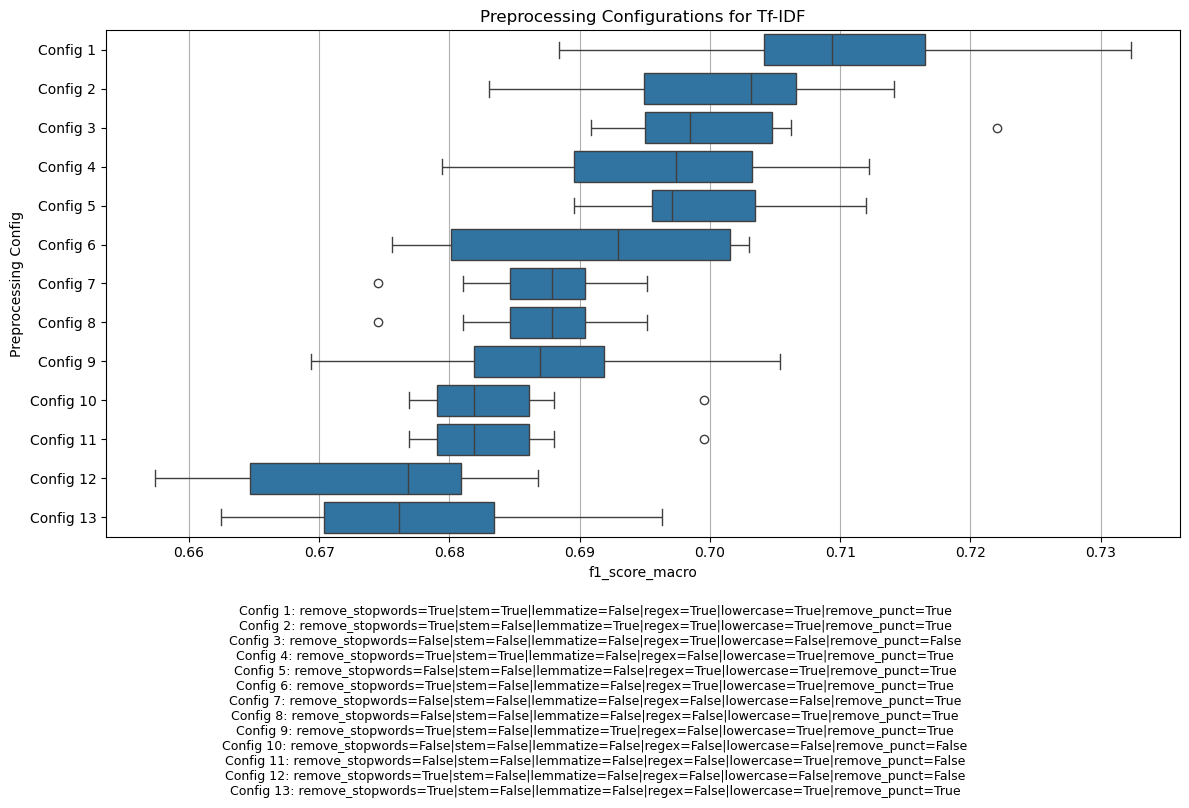

In [6]:

def extract_preprocessing_config(config):
    parts = config.split("|")
    # skip 'cv=1' (index 0), stop before 'feature_extractor='
    for i, p in enumerate(parts):
        if p.startswith("feature_extractor="):
            return "|".join(parts[1:i])  # exclude 'cv=' and feature extractor+
    return None

tf_res["preprocessing_config"] = tf_res["config"].apply(extract_preprocessing_config)

# Order by median f1 score
median_order = (
    tf_res.groupby("preprocessing_config")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Create config label mapping: "Config 1", "Config 2", ...
config_labels = {cfg: f"Config {i+1}" for i, cfg in enumerate(median_order)}

# Map short labels for plotting
tf_res["short_label"] = tf_res["preprocessing_config"].map(config_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=tf_res,
    x="f1_score_macro",
    y="short_label",
    order=[config_labels[cfg] for cfg in median_order],
    ax=ax,
    orient="h"
)

# Show all labels (you can add conditions here if needed)
ytick_labels = [config_labels[cfg] for cfg in median_order]
ax.set_yticklabels(ytick_labels)

# Title and axis
ax.set_title("Preprocessing Configurations for Tf-IDF")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Preprocessing Config")

# Optional legend below
full_legend_text = "\n".join(
    [f"{v}: {k}" for k, v in config_labels.items()]
)
plt.figtext(0.5, -0.33, full_legend_text, wrap=True, ha="center", fontsize=9)

plt.grid(True, axis='x')
plt.tight_layout()


/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/981006534.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_res["feature_config"] = tf_res["config"].apply(extract_feature_config)


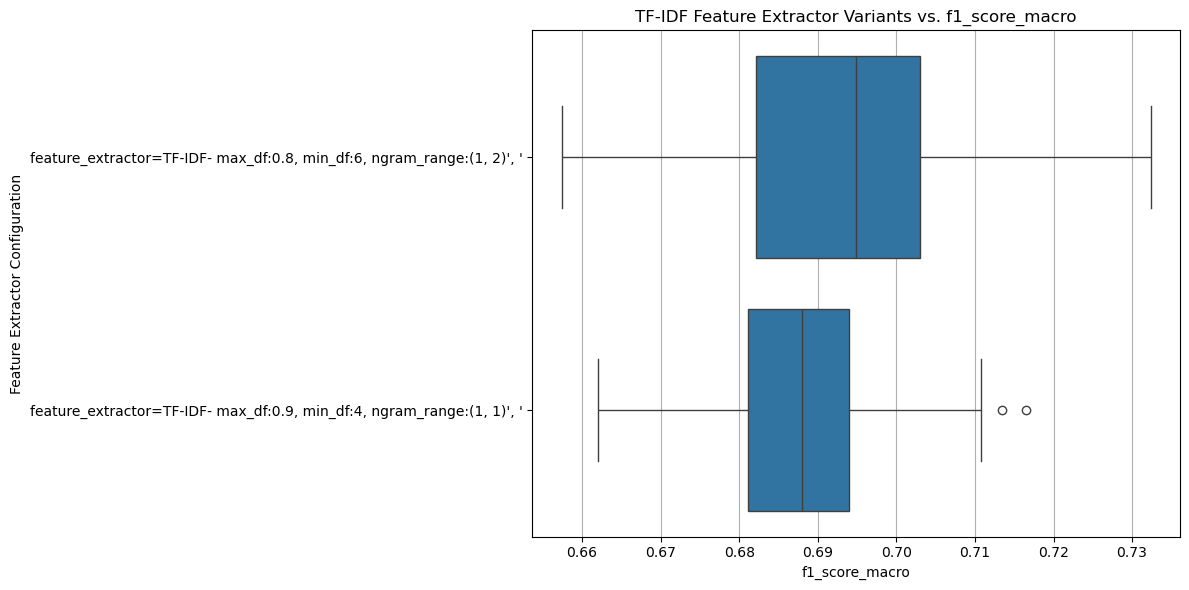

In [7]:
# Extract the feature extractor config
def extract_feature_config(config):
    parts = config.split("|")
    for p in parts:
        if p.startswith("feature_extractor="):
            return p
    return None

tf_res["feature_config"] = tf_res["config"].apply(extract_feature_config)

# Order by median score
median_order = (
    tf_res.groupby("feature_config")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=tf_res,
    x="f1_score_macro",
    y="feature_config",
    order=median_order,
    ax=ax,
    orient="h"
)

# Title and labels
ax.set_title("TF-IDF Feature Extractor Variants vs. f1_score_macro")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Feature Extractor Configuration")
ax.grid(True, axis='x')

plt.tight_layout()

In [8]:
sorted_means = (
    tf_res.groupby("final_config")["f1_score_macro"]
    .mean()
    .sort_values(ascending=False)
)

# Access the 4th entry (index 3)
final_config = sorted_means.index[:3]
score = sorted_means.iloc[:3]

print("Top 3 configurations based on mean f1_score_macro:")
for i, (config, mean_score) in enumerate(zip(final_config, score)):
    print(f"Config {i+1}: {config} - Mean f1_score_macro: {mean_score:.4f}")
    print("-" * 50)

Top 3 configurations based on mean f1_score_macro:
Config 1: remove_stopwords=True|stem=True|lemmatize=False|regex=True|lowercase=True|remove_punct=True|feature_extractor=TF-IDF- max_df:0.8, min_df:6, ngram_range:(1, 2)', '|Logistic_Regression') - Mean f1_score_macro: 0.7175
--------------------------------------------------
Config 2: remove_stopwords=False|stem=False|lemmatize=False|regex=True|lowercase=False|remove_punct=False|feature_extractor=TF-IDF- max_df:0.8, min_df:6, ngram_range:(1, 2)', '|Logistic_Regression') - Mean f1_score_macro: 0.7058
--------------------------------------------------
Config 3: remove_stopwords=True|stem=False|lemmatize=True|regex=True|lowercase=True|remove_punct=True|feature_extractor=TF-IDF- max_df:0.8, min_df:6, ngram_range:(1, 2)', '|Logistic_Regression') - Mean f1_score_macro: 0.7035
--------------------------------------------------


### Glove

In [9]:
for dim in [50, 100, 200]:
    #glove-twitter-25, 50, 100, 200
    glove_model = gensim.downloader.load(f'glove-twitter-{dim}')

    glove_embedder = make_embedding_transformer(glove_model, dim)

    test_feature_engineering(
        df_train=df_train,
        preprocessing_configs=preprocess_configurations,        # Preprocessing configurations
        pattern_meaning_dict=pattern_meaning_dict,          # Regex dict
        pattern_substitution_dict=pattern_substitution_dict,# Regex dict
        feature_extractor=glove_embedder,                # Feature extraction used
        feature_extractor_name="glove",
        params=f"glove-twitter-{dim}",
        results_file=results_file,                          # Result file
        tested_configs=tested_configs,                      # Tested Configs
        regex_flags=regex_flags,
        model_name="Logistic_Regression",
        embedder_name="GloVe",
        model=LogisticRegression(max_iter=2000)          # Model used to classify
    )

Skipping config already tested - configuration ('cv=1|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=glove- glove-twitter-50', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=2|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=glove- glove-twitter-50', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=3|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=glove- glove-twitter-50', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=4|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=glove- glove-twitter-50', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=5|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercas

In [10]:
glove_df = res[res["config"].str.contains("glove")]
glove_df

,config_number,config,model,accuracy,recall_macro,precision_macro,f1_score_macro,precision_per_class,recall_per_class,f1_per_class,final_config
130,GloVe_1,('cv=1|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.737559,0.564484,0.679454,0.597953,"[0.5783132530120482, 0.698744769874477, 0.7613...","[0.33217993079584773, 0.4348958333333333, 0.92...","[0.421978021978022, 0.536115569823435, 0.83576...",remove_stopwords=False|stem=False|lemmatize=Fa...
131,GloVe_1,('cv=2|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.737035,0.556518,0.670587,0.588194,"[0.5844155844155844, 0.6626016260162602, 0.764...","[0.31141868512110726, 0.4244791666666667, 0.93...","[0.40632054176072235, 0.5174603174603175, 0.84...",remove_stopwords=False|stem=False|lemmatize=Fa...
132,GloVe_1,('cv=3|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.751179,0.577083,0.707392,0.614279,"[0.6606060606060606, 0.6916299559471366, 0.769...","[0.3784722222222222, 0.4077922077922078, 0.944...","[0.4812362030905077, 0.5130718954248367, 0.848...",remove_stopwords=False|stem=False|lemmatize=Fa...
133,GloVe_1,('cv=4|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.737421,0.571293,0.672380,0.602313,"[0.6047904191616766, 0.6428571428571429, 0.769...","[0.3506944444444444, 0.44415584415584414, 0.91...","[0.44395604395604393, 0.5253456221198156, 0.83...",remove_stopwords=False|stem=False|lemmatize=Fa...
134,GloVe_1,('cv=5|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.742138,0.559167,0.703006,0.596683,"[0.6573426573426573, 0.6946902654867256, 0.756...","[0.3263888888888889, 0.4077922077922078, 0.943...","[0.4361948955916473, 0.513911620294599, 0.8399...",remove_stopwords=False|stem=False|lemmatize=Fa...
...,...,...,...,...,...,...,...,...,...,...,...
320,GloVe_13,('cv=1|remove_stopwords=True|stem=False|lemmat...,LogisticRegression,0.674711,0.465904,0.556336,0.481712,"[0.4369747899159664, 0.5148936170212766, 0.717...","[0.17993079584775087, 0.3151041666666667, 0.90...","[0.25490196078431376, 0.3909531502423263, 0.79...",remove_stopwords=True|stem=False|lemmatize=Tru...
321,GloVe_13,('cv=2|remove_stopwords=True|stem=False|lemmat...,LogisticRegression,0.690938,0.475666,0.585462,0.490256,"[0.5056179775280899, 0.5214007782101168, 0.729...","[0.15570934256055363, 0.3489583333333333, 0.92...","[0.23809523809523808, 0.4180967238689547, 0.81...",remove_stopwords=True|stem=False|lemmatize=Tru...
322,GloVe_13,('cv=3|remove_stopwords=True|stem=False|lemmat...,LogisticRegression,0.701469,0.501634,0.602283,0.519895,"[0.5283018867924528, 0.5333333333333333, 0.745...","[0.19444444444444445, 0.3948051948051948, 0.91...","[0.28426395939086296, 0.45373134328358206, 0.8...",remove_stopwords=True|stem=False|lemmatize=Tru...
323,GloVe_13,('cv=4|remove_stopwords=True|stem=False|lemmat...,LogisticRegression,0.681342,0.473910,0.569342,0.488407,"[0.5, 0.4782608695652174, 0.7297650130548303]","[0.1736111111111111, 0.34285714285714286, 0.90...","[0.25773195876288657, 0.3993948562783661, 0.80...",remove_stopwords=True|stem=False|lemmatize=Tru...


/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/3060518353.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glove_df["preprocessing_config"] = glove_df["config"].apply(extract_preprocessing_config)
/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/3060518353.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glove_df["short_label"] = glove_df["preprocessing_config"].map(config_labels)
/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/3060518353.py:38: User

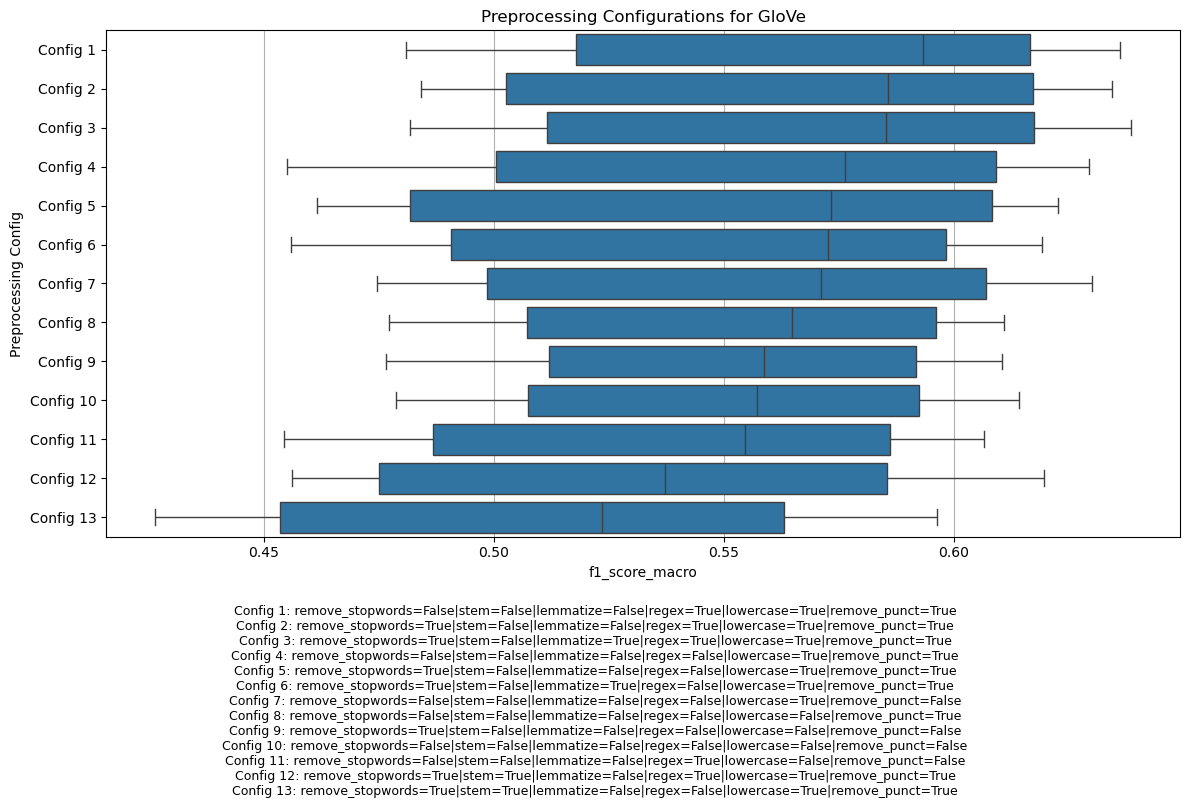

In [11]:
def extract_preprocessing_config(config):
    parts = config.split("|")
    # skip 'cv=1' (index 0), stop before 'feature_extractor='
    for i, p in enumerate(parts):
        if p.startswith("feature_extractor="):
            return "|".join(parts[1:i])  # exclude 'cv=' and feature extractor+
    return None

glove_df["preprocessing_config"] = glove_df["config"].apply(extract_preprocessing_config)

# Order by median f1 score
median_order = (
    glove_df.groupby("preprocessing_config")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Create config label mapping: "Config 1", "Config 2", ...
config_labels = {cfg: f"Config {i+1}" for i, cfg in enumerate(median_order)}

# Map short labels for plotting
glove_df["short_label"] = glove_df["preprocessing_config"].map(config_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=glove_df,
    x="f1_score_macro",
    y="short_label",
    order=[config_labels[cfg] for cfg in median_order],
    ax=ax,
    orient="h"
)

# Show all labels (you can add conditions here if needed)
ytick_labels = [config_labels[cfg] for cfg in median_order]
ax.set_yticklabels(ytick_labels)

# Title and axis
ax.set_title("Preprocessing Configurations for GloVe")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Preprocessing Config")

# Optional legend below
full_legend_text = "\n".join(
    [f"{v}: {k}" for k, v in config_labels.items()]
)
plt.figtext(0.5, -0.33, full_legend_text, wrap=True, ha="center", fontsize=9)

plt.grid(True, axis='x')
plt.tight_layout()


/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/1845636810.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glove_df["feature_config"] = glove_df["config"].apply(extract_feature_config)


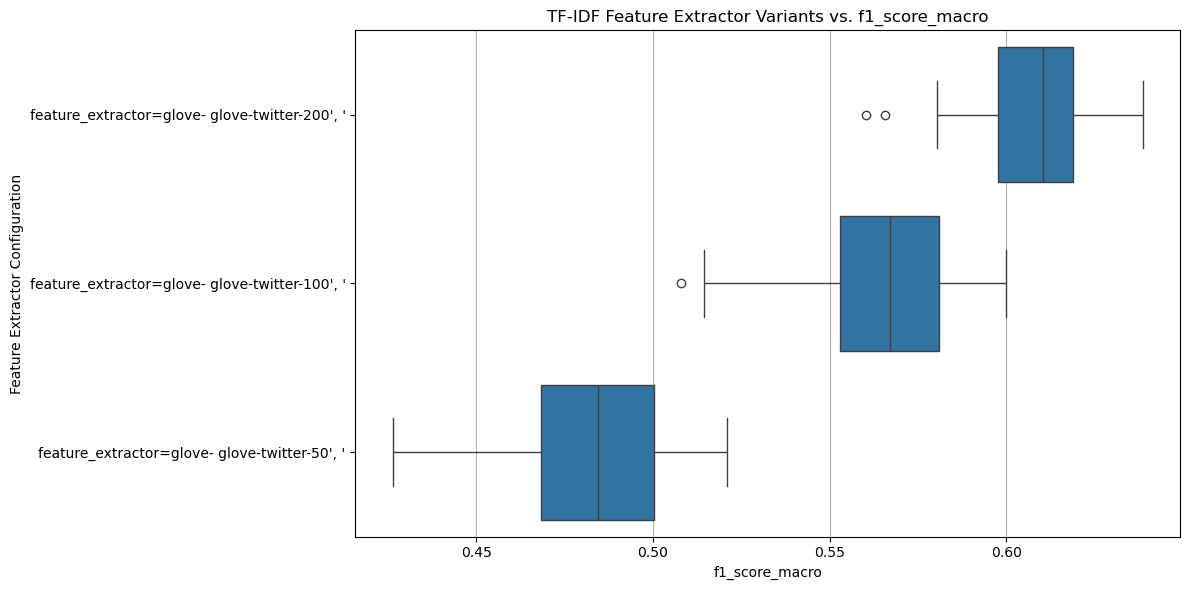

In [12]:
# Extract the feature extractor config
def extract_feature_config(config):
    parts = config.split("|")
    for p in parts:
        if p.startswith("feature_extractor="):
            return p
    return None

glove_df["feature_config"] = glove_df["config"].apply(extract_feature_config)

# Order by median score
median_order = (
    glove_df.groupby("feature_config")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=glove_df,
    x="f1_score_macro",
    y="feature_config",
    order=median_order,
    ax=ax,
    orient="h"
)

# Title and labels
ax.set_title("TF-IDF Feature Extractor Variants vs. f1_score_macro")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Feature Extractor Configuration")
ax.grid(True, axis='x')

plt.tight_layout()

In [13]:
sorted_means = (
    glove_df.groupby("final_config")["f1_score_macro"]
    .mean()
    .sort_values(ascending=False)
)

# Access the 4th entry (index 3)
final_config = sorted_means.index[:3]
score = sorted_means.iloc[:3]

print("Top 3 configurations based on mean f1_score_macro:")
for i, (config, mean_score) in enumerate(zip(final_config, score)):
    print(f"Config {i+1}: {config} - Mean f1_score_macro: {mean_score:.4f}")
    print("-" * 50)

Top 3 configurations based on mean f1_score_macro:
Config 1: remove_stopwords=True|stem=False|lemmatize=True|regex=True|lowercase=True|remove_punct=True|feature_extractor=glove- glove-twitter-200', '|Logistic_Regression') - Mean f1_score_macro: 0.6268
--------------------------------------------------
Config 2: remove_stopwords=False|stem=False|lemmatize=False|regex=True|lowercase=True|remove_punct=True|feature_extractor=glove- glove-twitter-200', '|Logistic_Regression') - Mean f1_score_macro: 0.6254
--------------------------------------------------
Config 3: remove_stopwords=True|stem=False|lemmatize=False|regex=True|lowercase=True|remove_punct=True|feature_extractor=glove- glove-twitter-200', '|Logistic_Regression') - Mean f1_score_macro: 0.6227
--------------------------------------------------


### Transformers - Encoders

In [14]:
model = "zcharaf/FinBerta" 

embedder = HF_Transformer_Embedding(
    model_name=model,
    batch_size=128)

test_feature_engineering(
    df_train=df_train,
    preprocessing_configs=preprocess_configurations,        # Preprocessing configurations
    pattern_meaning_dict=pattern_meaning_dict,          # Regex dict
    pattern_substitution_dict=pattern_substitution_dict,# Regex dict
    results_file=results_file,                          # Result file
    tested_configs=tested_configs,                      # Tested Configs
    # Don't have to change this above
    feature_extractor_name=model,
    params=f"",
    regex_flags=regex_flags,
    feature_extractor=embedder,                # Feature extraction used
    embedder_name="Encoder-Bert-like",
    model_name="Logistic_Regression",
    model=LogisticRegression(max_iter=2000)          # Model used to classify
)



tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Skipping config already tested - configuration ('cv=1|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=zcharaf/FinBerta- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=2|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=zcharaf/FinBerta- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=3|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=zcharaf/FinBerta- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=4|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=zcharaf/FinBerta- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=5|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct

In [15]:
encoder_df = res[res["config"].str.contains("zcharaf/FinBerta")]

/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/1756546905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoder_df["preprocessing_config"] = encoder_df["config"].apply(extract_preprocessing_config)
/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/1756546905.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoder_df["short_label"] = encoder_df["preprocessing_config"].map(config_labels)
/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/1756546905.py:

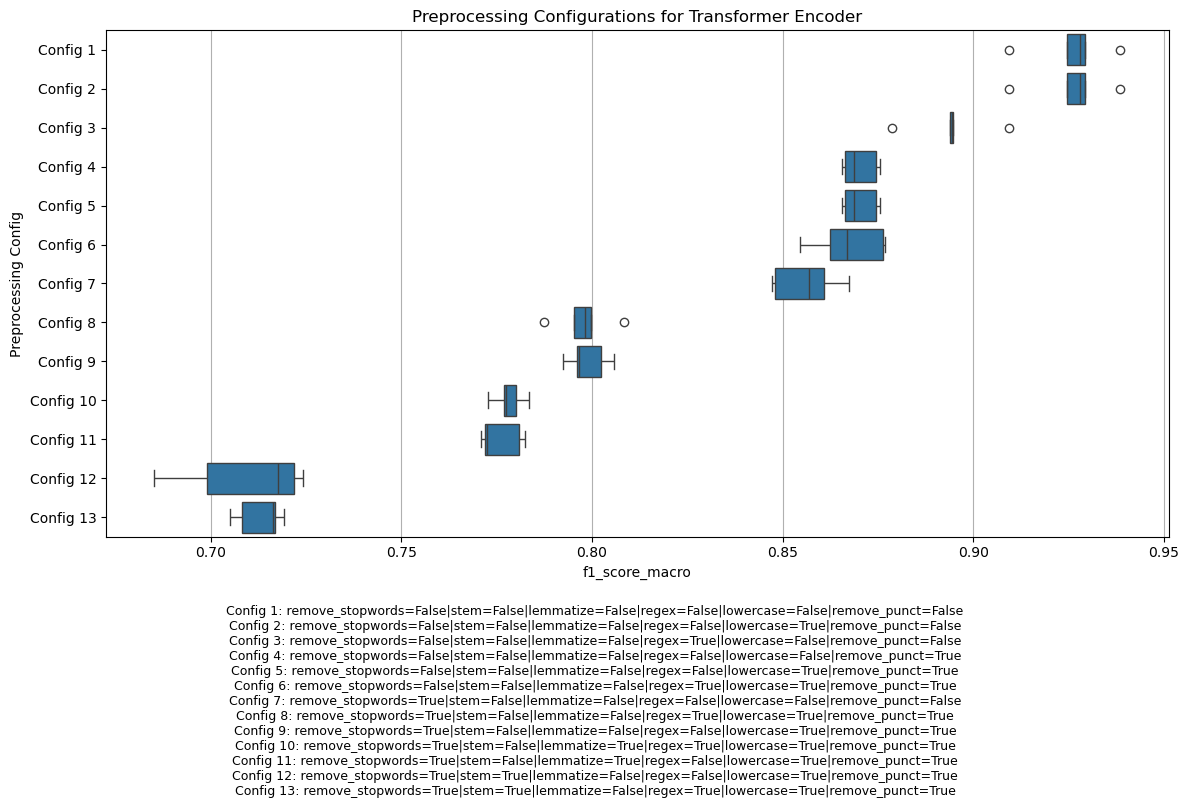

In [16]:
def extract_preprocessing_config(config):
    parts = config.split("|")
    # skip 'cv=1' (index 0), stop before 'feature_extractor='
    for i, p in enumerate(parts):
        if p.startswith("feature_extractor="):
            return "|".join(parts[1:i])  # exclude 'cv=' and feature extractor+
    return None

encoder_df["preprocessing_config"] = encoder_df["config"].apply(extract_preprocessing_config)

# Order by median f1 score
median_order = (
    encoder_df.groupby("preprocessing_config")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Create config label mapping: "Config 1", "Config 2", ...
config_labels = {cfg: f"Config {i+1}" for i, cfg in enumerate(median_order)}

# Map short labels for plotting
encoder_df["short_label"] = encoder_df["preprocessing_config"].map(config_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=encoder_df,
    x="f1_score_macro",
    y="short_label",
    order=[config_labels[cfg] for cfg in median_order],
    ax=ax,
    orient="h"
)

# Show all labels (you can add conditions here if needed)
ytick_labels = [config_labels[cfg] for cfg in median_order]
ax.set_yticklabels(ytick_labels)

# Title and axis
ax.set_title("Preprocessing Configurations for Transformer Encoder")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Preprocessing Config")

# Optional legend below
full_legend_text = "\n".join(
    [f"{v}: {k}" for k, v in config_labels.items()]
)
plt.figtext(0.5, -0.33, full_legend_text, wrap=True, ha="center", fontsize=9)

plt.grid(True, axis='x')
plt.tight_layout()


We will proceed now without preprocessing to achieve better results <br>
We will compare different encoders from HuggingFace fine tunned for financial data

In [17]:
preprocess_configurations = [
    {
        "stem": False,
        "lemmatize": False,
        "remove_stopwords": False,
        "regex": False,
        "lowercase": False,
        "remove_punct": False,
    },
]

for model in [
    "HugMaik/financial-twitter-sentiment-model",
    "RashidNLP/Finance-Sentiment-Classification",
    "zcharaf/FinBerta"
]:
    print(f"Testing model: {model}")
    
    embedder = HF_Transformer_Embedding(
        model_name=model,
        batch_size=128)

    test_feature_engineering(
        df_train=df_train,
        preprocessing_configs=preprocess_configurations,        # Preprocessing configurations
        pattern_meaning_dict=pattern_meaning_dict,          # Regex dict
        pattern_substitution_dict=pattern_substitution_dict,# Regex dict
        results_file=results_file,                          # Result file
        tested_configs=tested_configs,                      # Tested Configs
        # Don't have to change this above
        feature_extractor_name=model,
        params=f"",
        regex_flags=regex_flags,
        feature_extractor=embedder,                # Feature extraction used
        embedder_name="Encoder-Bert-like",
        model_name="Logistic_Regression",
        model=LogisticRegression(max_iter=2000)          # Model used to classify
    )



Testing model: HugMaik/financial-twitter-sentiment-model


tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Skipping config already tested - configuration ('cv=1|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=HugMaik/financial-twitter-sentiment-model- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=2|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=HugMaik/financial-twitter-sentiment-model- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=3|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=HugMaik/financial-twitter-sentiment-model- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=4|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=HugMaik/financial-twitter-sentiment-model- ', '|Logistic_Regression')
Skipping config already tested - configurati

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Skipping config already tested - configuration ('cv=1|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=RashidNLP/Finance-Sentiment-Classification- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=2|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=RashidNLP/Finance-Sentiment-Classification- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=3|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=RashidNLP/Finance-Sentiment-Classification- ', '|Logistic_Regression')
Skipping config already tested - configuration ('cv=4|remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=RashidNLP/Finance-Sentiment-Classification- ', '|Logistic_Regression')
Skipping config already tested - configu

In [18]:
encoder_final_df = res[res["config"].str.contains("HugMaik/financial-twitter-sentiment-model|RashidNLP/Finance-Sentiment-Classification|zcharaf/FinBerta")]

encoder_final_df = encoder_final_df[
    encoder_final_df["config"].str.contains(
        "remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False",
        regex=False
    )
]
encoder_final_df = encoder_final_df[encoder_final_df["config_number"].str.contains("Encoder-Bert-like")]

In [19]:
encoder_final_df

,config_number,config,model,accuracy,recall_macro,precision_macro,f1_score_macro,precision_per_class,recall_per_class,f1_per_class,final_config
325,Encoder-Bert-like_1,('cv=1|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.945521,0.923955,0.932173,0.927981,"[0.9107142857142857, 0.9267015706806283, 0.959...","[0.8823529411764706, 0.921875, 0.9676375404530...","[0.8963093145869947, 0.9242819843342037, 0.963...",remove_stopwords=False|stem=False|lemmatize=Fa...
326,Encoder-Bert-like_1,('cv=2|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.936616,0.905433,0.913220,0.909261,"[0.8631578947368421, 0.9173333333333333, 0.959...","[0.8512110726643599, 0.8958333333333334, 0.969...","[0.8571428571428571, 0.9064558629776022, 0.964...",remove_stopwords=False|stem=False|lemmatize=Fa...
327,Encoder-Bert-like_1,('cv=3|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.952331,0.938946,0.938218,0.938569,"[0.9106529209621993, 0.93717277486911, 0.96682...","[0.9201388888888888, 0.9298701298701298, 0.966...","[0.915371329879102, 0.9335071707953063, 0.9668...",remove_stopwords=False|stem=False|lemmatize=Fa...
328,Encoder-Bert-like_1,('cv=4|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.944444,0.927180,0.922070,0.924548,"[0.8720538720538721, 0.9267015706806283, 0.967...","[0.8993055555555556, 0.9194805194805195, 0.962...","[0.8854700854700855, 0.9230769230769231, 0.965...",remove_stopwords=False|stem=False|lemmatize=Fa...
329,Encoder-Bert-like_1,('cv=5|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.945493,0.932461,0.926445,0.929418,"[0.8976109215017065, 0.9151670951156813, 0.966...","[0.9131944444444444, 0.9246753246753247, 0.959...","[0.9053356282271945, 0.9198966408268734, 0.963...",remove_stopwords=False|stem=False|lemmatize=Fa...
390,Encoder-Bert-like_1,('cv=1|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.961760,0.954777,0.953203,0.953966,"[0.9581881533101045, 0.9282051282051282, 0.973...","[0.9515570934256056, 0.9427083333333334, 0.970...","[0.9548611111111112, 0.9354005167958657, 0.971...",remove_stopwords=False|stem=False|lemmatize=Fa...
391,Encoder-Bert-like_1,('cv=2|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.960189,0.943225,0.957276,0.950051,"[0.9646643109540636, 0.9429347826086957, 0.964...","[0.9446366782006921, 0.9036458333333334, 0.981...","[0.9545454545454545, 0.922872340425532, 0.9727...",remove_stopwords=False|stem=False|lemmatize=Fa...
392,Encoder-Bert-like_1,('cv=3|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.969618,0.959982,0.966834,0.963321,"[0.9652777777777778, 0.9624664879356568, 0.972...","[0.9652777777777778, 0.9324675324675324, 0.982...","[0.9652777777777778, 0.9472295514511874, 0.977...",remove_stopwords=False|stem=False|lemmatize=Fa...
393,Encoder-Bert-like_1,('cv=4|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.958071,0.948423,0.948973,0.948697,"[0.9409722222222222, 0.9375, 0.9684466019417476]","[0.9409722222222222, 0.935064935064935, 0.9692...","[0.9409722222222222, 0.9362808842652797, 0.968...",remove_stopwords=False|stem=False|lemmatize=Fa...
394,Encoder-Bert-like_1,('cv=5|remove_stopwords=False|stem=False|lemma...,LogisticRegression,0.970126,0.963835,0.962238,0.963013,"[0.965034965034965, 0.9411764705882353, 0.9805...","[0.9583333333333334, 0.9558441558441558, 0.977...","[0.9616724738675957, 0.9484536082474226, 0.978...",remove_stopwords=False|stem=False|lemmatize=Fa...


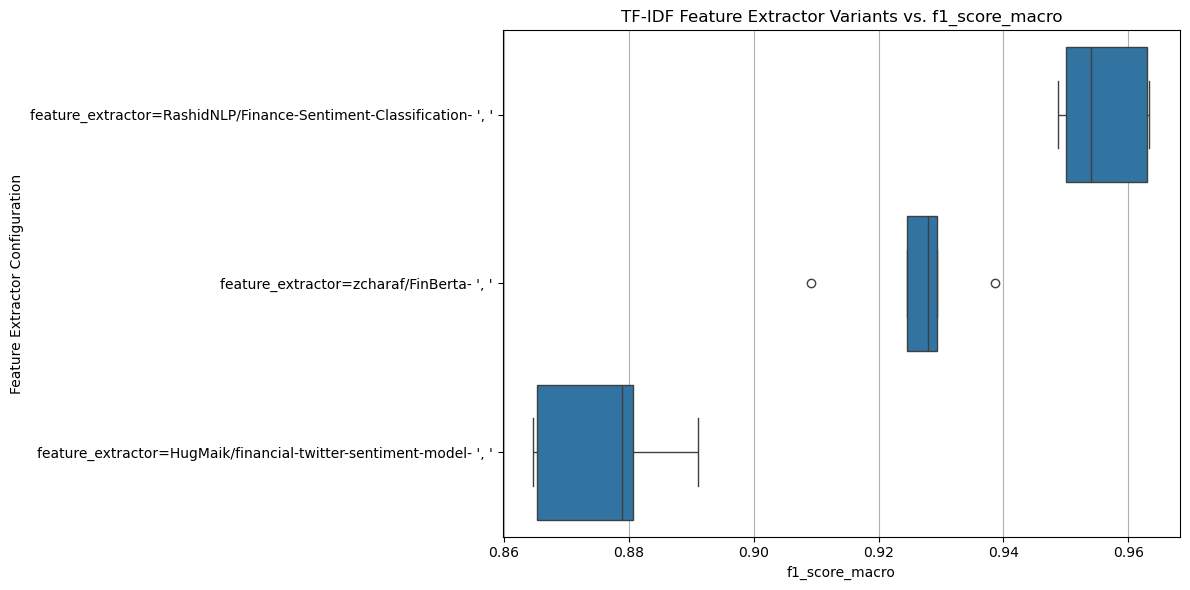

In [20]:
# Extract the feature extractor config
def extract_feature_config(config):
    parts = config.split("|")
    for p in parts:
        if p.startswith("feature_extractor="):
            return p
    return None

encoder_final_df["feature_config"] = encoder_final_df["config"].apply(extract_feature_config)

# Order by median score
median_order = (
    encoder_final_df.groupby("feature_config")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=encoder_final_df,
    x="f1_score_macro",
    y="feature_config",
    order=median_order,
    ax=ax,
    orient="h"
)

# Title and labels
ax.set_title("TF-IDF Feature Extractor Variants vs. f1_score_macro")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Feature Extractor Configuration")
ax.grid(True, axis='x')

plt.tight_layout()

In [21]:
sorted_means = (
    encoder_final_df.groupby("final_config")["f1_score_macro"]
    .mean()
    .sort_values(ascending=False)
)

# Access the 4th entry (index 3)
final_config = sorted_means.index[:3]
score = sorted_means.iloc[:3]

print("Top 3 configurations based on mean f1_score_macro:")
for i, (config, mean_score) in enumerate(zip(final_config, score)):
    print(f"Config {i+1}: {config} - Mean f1_score_macro: {mean_score:.4f}")
    print("-" * 50)

Top 3 configurations based on mean f1_score_macro:
Config 1: remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=RashidNLP/Finance-Sentiment-Classification- ', '|Logistic_Regression') - Mean f1_score_macro: 0.9558
--------------------------------------------------
Config 2: remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=zcharaf/FinBerta- ', '|Logistic_Regression') - Mean f1_score_macro: 0.9260
--------------------------------------------------
Config 3: remove_stopwords=False|stem=False|lemmatize=False|regex=False|lowercase=False|remove_punct=False|feature_extractor=HugMaik/financial-twitter-sentiment-model- ', '|Logistic_Regression') - Mean f1_score_macro: 0.8762
--------------------------------------------------


"RashidNLP" is the best performing encoder

# Classifiers

We will use the best transformer encoder fine tuned for financial data derived from Debert ("RashidNLP/Finance-Sentiment-Classification")<br>
We different classifiers:
- KNN 
- SVM
- Logistic Regression 
- Random Forest 
- Transformer Head Classifier (NN)

In [9]:

classifiers_to_test_grid = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': [{
            'n_neighbors': [5, 15, 10, 20],
            'weights': ['uniform', 'distance'],
            'n_jobs': [-1]
        }]
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'param_grid': [
            {
                'penalty': ['l1'],
                'C': [0.1, 1.0, 10.0],
                'solver': ['liblinear'], # 'l1' penalty requires 'liblinear' or 'saga'
                'max_iter': [1500],
                'random_state': [42]
            },
            {
                'penalty': ['l2'],
                'C': [0.1, 1.0, 10.0],
                'solver': ['lbfgs'],    # 'lbfgs' is a common default for 'l2'
                'max_iter': [1500],
                'random_state': [42]
            }
        ]
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': [{
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 15],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [42],
            'n_jobs': [-1]
        }]
    },
    'SVC': {
        'model': SVC(),
        'param_grid': [
            {
                'C': [0.1, 1, 10],
                'kernel': ['linear'],
                'probability': [True],
                'random_state': [42]
            },
            {
                'C': [0.1, 1, 10],
                'kernel': ['rbf'],
                'gamma': ['scale', 'auto'],
                'probability': [True],
                'random_state': [42]
            }
        ]
    }
}



In [10]:
n_splits = 5
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for i, (train_index, val_index) in enumerate(stratified_kf.split(df_train['text'], df_train['label'])):
    # --- Configuration ---
    preprocess = False
    simple_preprocess = True
    regex = False
    model = "RashidNLP/Finance-Sentiment-Classification"

    
    batch_size = 16
    cv = f"cv={i+1}"
    preprocess_config = f"preprocess={preprocess}|regex={regex}"

    print(f"Fold {i+1}")
    print("-" * 80)

    # --- Data splitting and text preprocessing ---
    X_train, X_val = df_train['text'].iloc[train_index], df_train['text'].iloc[val_index]
    y_train, y_val = df_train['label'].iloc[train_index], df_train['label'].iloc[val_index]

    if preprocess:
        X_train = X_train.apply(
            lambda x: processing_text(x, regex_flags=regex_flags, regex=regex, re_expressions=pattern_meaning_dict, substitution=pattern_substitution_dict)
        )
        X_val = X_val.apply(
            lambda x: processing_text(x, regex_flags=regex_flags, regex=regex, re_expressions=pattern_meaning_dict, substitution=pattern_substitution_dict)
        )
        
    if simple_preprocess:
        def normalize_text(s, sep_token = " \n "):
            s = re.sub(r'\s+',  ' ', s).strip() # extra whitespace
            s = re.sub(r'\.\s*,', '', s) # pattern . , 
            s = s.replace("..",".")
            s = s.replace(". .",".")
            s = s.replace("\n", "")
            s = s.strip()
            
            return s
    
        X_train = X_train.apply(normalize_text)
        X_val = X_val.apply(normalize_text)
        
    # # --- Generate Embeddings ---
    embedder = HF_Transformer_Embedding(
        model_name=model,
        batch_size=128)
    
    X_train_embeddings = embedder.transform(X_train)
    X_val_embeddings = embedder.transform(X_val)

    # --- Loop through classifiers and their parameter grids ---
    for clf_name, clf_info in classifiers_to_test_grid.items():

        # Loop through each grid definition
        for grid in clf_info['param_grid']:
            # Get parameter names and their value lists
            param_keys = list(grid.keys())
            param_values = list(grid.values())

            # Generate all parameter combinations from the current grid
            for combination in itertools.product(*param_values):
                # Create the parameter dictionary for this specific combination
                params = dict(zip(param_keys, combination))

                params_str = format_params_for_config(params)
                config_id = f"{cv}|{preprocess_config}|{model}|{clf_name}|{params_str}"

                if config_id not in tested_configs:
                    # print(f"--- Testing Classifier: {clf_name} ---")

                    # 1. Initialize the model with its parameters
                    # print(f"Parameters: {params_str}")
                    classifier = clf_info['model']
                    classifier.set_params(**params)

                    # 2. Train the classifier
                    # print(f"Training {clf_name}...")
                    classifier.fit(X_train_embeddings, y_train)

                    # 3. Make predictions
                    preds_label = classifier.predict(X_val_embeddings)

                    # 4. Evaluate and save results
                    results = get_results(y_val, preds_label)
                    results['config'] = config_id
                    results['model'] = f"{clf_name}(on_{model.split('/')[-1]})"

                    print(f"Results for {clf_name} with {params_str}: F1-Macro = {round(results['f1_macro'], 4)}")

                    save_results_to_csv(
                        embedder=model,
                        config_id=config_id,
                        config_number='',
                        model_name=results['model'],
                        results=results,
                        results_file=results_file,
                        tested_configs=tested_configs
                    )
                else:
                    print(f"Skipping {clf_name} with config: {config_id} (already tested)")
    
    # --------------- Encoder Head 
    config_id = f"{cv}|{preprocess_config}|{model}|EncoderHead"
    if config_id in tested_configs:
        print(f"Skipping Encoder Head with config: {config_id} (already tested)")
        continue
    
    pipe = pipeline(
        "text-classification", 
        model=model, 
        tokenizer=model, 
        batch_size=128,
        device_map="cuda",
        truncation=True,
        return_all_scores=True,
    )

    
    preds = pipe(X_val.tolist())


    probas = []
    for pred in preds:
        scores = [item['score'] for item in pred]
        probas.append(scores)
    
    encoder_preds = [int(np.argmax(item)) for item in probas]
    
    results = get_results(y_val, encoder_preds)
    
    results['config'] = f"{cv}|{preprocess_config}|{model}|EncoderHead"
    results['model'] = f"EncoderHead(on_{model.split('/')[-1]})"
    print(f"Results for {model} with EncoderHead: F1-Macro = {round(results['f1_macro'], 4)}")

    save_results_to_csv(
        embedder=model,
        config_id=config_id,
        config_number='',
        model_name=results['model'],
        results=results,
        results_file=results_file,
        tested_configs=tested_configs
    )

    print("=" * 80)

Fold 1
--------------------------------------------------------------------------------
Skipping KNN with config: cv=1|preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|KNN|n_neighbors=5|weights=uniform|n_jobs=-1 (already tested)
Skipping KNN with config: cv=1|preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|KNN|n_neighbors=5|weights=distance|n_jobs=-1 (already tested)
Skipping KNN with config: cv=1|preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|KNN|n_neighbors=15|weights=uniform|n_jobs=-1 (already tested)
Skipping KNN with config: cv=1|preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|KNN|n_neighbors=15|weights=distance|n_jobs=-1 (already tested)
Skipping KNN with config: cv=1|preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|KNN|n_neighbors=10|weights=uniform|n_jobs=-1 (already tested)
Skipping KNN with config: cv=1|preprocess=False|regex=False|RashidNLP/Finance-Sentiment

### Transformers - Encoder

We will also test with LLama encoder (zero-shot)

In [13]:
for i, (train_index, val_index) in enumerate(stratified_kf.split(df_train['text'], df_train['label'])):
    # nota os primerios foram 128 
    batch_size_train = 128
    learning_rate = 1.7e-5
    epochs = 4
    weight_decay = 0.01
    
    
    decoder_name = "arcee-ai/Llama-3.1-SuperNova-Lite" # 72,7 
    
    # nota os primerios foram 128 
    batch_size = 128

    cv = f"cv={i+1}"
    
    X_train, X_val = df_train['text'].iloc[train_index], df_train['text'].iloc[val_index]
    y_train, y_val = df_train['label'].iloc[train_index], df_train['label'].iloc[val_index]

        
    # --------------- New preprocessing 
    
    def normalize_text(s, sep_token = " \n "):
        s = re.sub(r'\s+',  ' ', s).strip() # extra whitespace
        s = re.sub(r'\.\s*,', '', s) # pattern . , 
        s = s.replace("..",".")
        s = s.replace(". .",".")
        s = s.replace("\n", "")
        s = s.strip()
        
        return s
    
    X_train_processed = X_train.apply(normalize_text)
    X_val_processed = X_val.apply(normalize_text)



    # -------------- Classify with LLM 
    
    config_id = f"{cv}|{decoder_name}|LLM predictions"
    
    if config_id in tested_configs:
        print(f"Skipping LLM predictions with config: {config_id} (already tested)")
        continue
    
    tokenizer = AutoTokenizer.from_pretrained(decoder_name)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    model = AutoModelForCausalLM.from_pretrained(
        decoder_name,
        torch_dtype=torch.bfloat16,
        device_map="cuda",
        low_cpu_mem_usage=True,
        trust_remote_code=True,
    )
    
    
    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        return_full_text=False,
        max_new_tokens=100,
        do_sample=False,
        )
    
    system_message = (
        "You are a financial sentiment classifier. "
        "Classify the following tweet as Bearish (0), Bullish (1), or Neutral (2). "
        #"Please reclassify it based on the context provided. "
        "Respond with ONLY a valid JSON object in this format: {\"label\": \"0\"} — nothing else."
        )
    
    batch_size = 8
    
    batched_prompts = []
    for text in X_val_processed.tolist():
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": text}
        ]
        batched_prompts.append(messages)
    
    preds_decoder = []        
    for i in tqdm(range(0, len(batched_prompts), batch_size), desc="Generating LLM predictions", leave=True):
        batch = batched_prompts[i:i + batch_size]
        responses = generator(batch, batch_size=batch_size)

        for response in responses:
            generated_text = response[0]["generated_text"].strip()
            try:
                json_part = generated_text[generated_text.find('{'):generated_text.find('}')+1]
                label = json.loads(json_part).get("label", None)
                if label in {'0', '1', '2'}:
                    preds_decoder.append(int(label))
                else:
                    preds_decoder.append(-1)
            except json.JSONDecodeError:
                preds_decoder.append(-1)
            
    
    # -------------- Compare results with original predictions

    acc_dec, rec_dec, prec_dec, f1_dec, precision_arr_dec, recall_arr_dec, f1_arr_dec = get_metrics(y_val, preds_decoder)

    print(f"Decoder predictions - Accuracy: {acc_dec:.4f}, Recall: {rec_dec:.4f}, Precision: {prec_dec:.4f}, F1: {f1_dec:.4f}")

    results = get_results(y_val, preds_decoder)
    results['config'] = config_id
    results['model'] = f"LLM predictions(on_{decoder_name.split('/')[-1]})"
    
    save_results_to_csv(
        embedder=decoder_name,
        config_id=config_id,
        config_number='',
        model_name=results['model'],
        results=results,
        results_file=results_file,
        tested_configs=tested_configs
    )
    print("=" * 80)

Skipping LLM predictions with config: cv=1|arcee-ai/Llama-3.1-SuperNova-Lite|LLM predictions (already tested)
Skipping LLM predictions with config: cv=2|arcee-ai/Llama-3.1-SuperNova-Lite|LLM predictions (already tested)
Skipping LLM predictions with config: cv=3|arcee-ai/Llama-3.1-SuperNova-Lite|LLM predictions (already tested)
Skipping LLM predictions with config: cv=4|arcee-ai/Llama-3.1-SuperNova-Lite|LLM predictions (already tested)
Skipping LLM predictions with config: cv=5|arcee-ai/Llama-3.1-SuperNova-Lite|LLM predictions (already tested)


/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_86450/2086964089.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels)


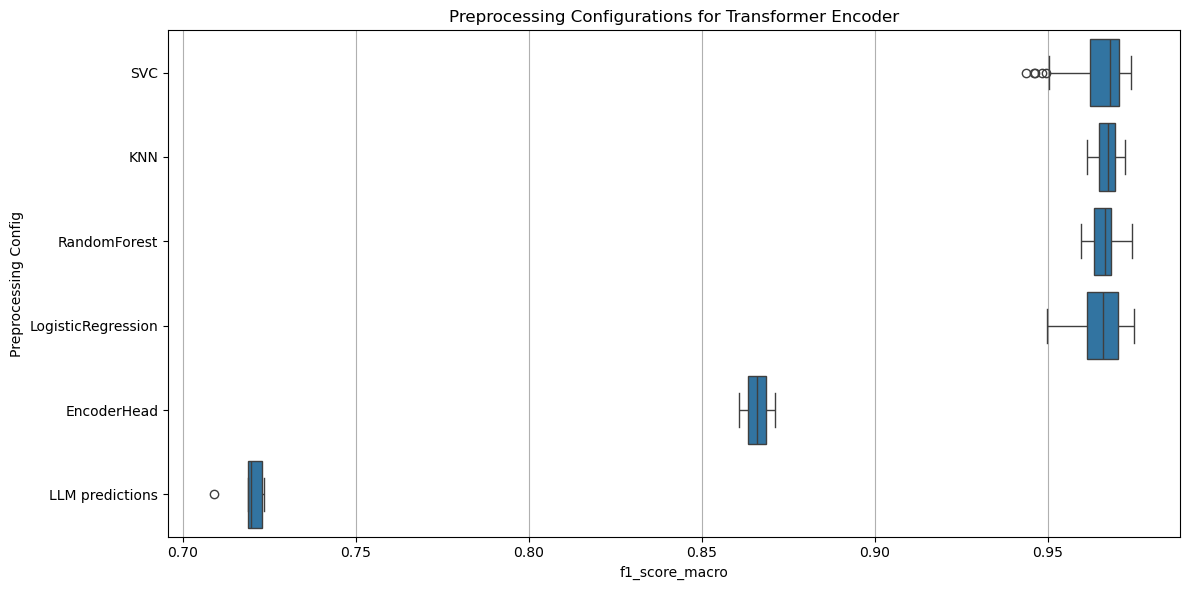

In [22]:
class_df = res[res["config_number"].str.contains("RashidNLP/Finance-Sentiment-Classification")]

class_df = class_df[:-20]

llama_df = res[res["config"].str.contains("LLM predictions")]
class_df = pd.concat([class_df, llama_df], axis=0)

# Order by median f1 score
median_order = (
    class_df.groupby("model")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Create config label mapping: "Config 1", "Config 2", ...
config_labels = {cfg: f"{cfg.split('(')[0]}" for cfg in median_order}

# Map short labels for plotting
class_df["short_label"] = class_df["model"].map(config_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=class_df,
    x="f1_score_macro",
    y="short_label",
    order=[config_labels[cfg] for cfg in median_order],
    ax=ax,
    orient="h"
)

# Show all labels (you can add conditions here if needed)
ytick_labels = [config_labels[cfg] for cfg in median_order]
ax.set_yticklabels(ytick_labels)

# Title and axis
ax.set_title("Preprocessing Configurations for Transformer Encoder")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Preprocessing Config")


plt.grid(True, axis='x')
plt.tight_layout()

In [26]:
sorted_means = (
    class_df.groupby("final_config")["f1_score_macro"]
    .mean()
    .sort_values(ascending=False)
)

# Access the 4th entry (index 3)
final_config = sorted_means.index[:3]
score = sorted_means.iloc[:3]

print("Top 3 configurations based on mean f1_score_macro:")
for i, (config, mean_score) in enumerate(zip(final_config, score)):
    print(f"Config {i+1}: {config} - Mean f1_score_macro: {mean_score:.4f}")
    print("-" * 50)

Top 3 configurations based on mean f1_score_macro:
Config 1: preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|SVC|C=10|kernel=rbf|gamma=scale|probability=True|random_state=42 - Mean f1_score_macro: 0.9720
--------------------------------------------------
Config 2: preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|LogisticRegression|penalty=l1|C=0.1|solver=liblinear|max_iter=1000|random_state=42 - Mean f1_score_macro: 0.9718
--------------------------------------------------
Config 3: preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|SVC|C=1|kernel=rbf|gamma=auto|probability=True|random_state=42 - Mean f1_score_macro: 0.9712
--------------------------------------------------


# Fine-tune embedder

In [14]:
for i, (train_index, val_index) in enumerate(stratified_kf.split(df_train['text'], df_train['label'])):
    # nota os primerios foram 128 
    batch_size_train = 128
    learning_rate = 1.7e-5
    epochs = 3
    weight_decay = 0.01
    scheduler = "cosine"
    

    model_name = "RashidNLP/Finance-Sentiment-Classification" 


    batch_size = 128

    cv = f"cv={i+1}"
    
    print(f"Fold {i+1}")
    X_train, X_val = df_train['text'].iloc[train_index], df_train['text'].iloc[val_index]
    y_train, y_val = df_train['label'].iloc[train_index], df_train['label'].iloc[val_index]

        
    # --------------- New preprocessing 
    
    def normalize_text(s, sep_token = " \n "):
        s = re.sub(r'\s+',  ' ', s).strip() # extra whitespace
        s = re.sub(r'\.\s*,', '', s) # pattern . , 
        s = s.replace("..",".")
        s = s.replace(". .",".")
        s = s.replace("\n", "")
        s = s.strip()
        
        return s
    
    X_train_processed = X_train.apply(normalize_text)
    X_val_processed = X_val.apply(normalize_text)

        
    # -------------- FineTune the model 
    # -------------- Classification head 

    config_id = f"{cv}|{model_name}|FineTune - epochs:{epochs}, batch_size_train:{batch_size_train}, learning_rate:{learning_rate}, weight_decay:{weight_decay}, scheduler:{scheduler}|ClassificationHead"
    
    config_id_2 = f"{cv}|{model_name}|FineTune - epochs:{epochs}, batch_size_train:{batch_size_train}, learning_rate:{learning_rate}, weight_decay:{weight_decay}, scheduler:{scheduler}|SVC_best"
    
    config_id_3 = f"{cv}|{model_name}|FineTune - epochs:{epochs}, batch_size_train:{batch_size_train}, learning_rate:{learning_rate}, weight_decay:{weight_decay}, scheduler:{scheduler}|LR_best"
    
    if config_id in tested_configs and config_id_2 in tested_configs and config_id_3 in tested_configs:
        print(f"Skipping FineTune with config: {config_id} (already tested)")
        
    train_data = {
        "text": X_train_processed.tolist(),
        "label": y_train.tolist()  
        }
    
    val_data = {
        "text": X_val_processed.tolist(),
        "label": y_val.tolist() 
        }
    
    train_dataset = Dataset.from_dict(train_data)
    val_dataset = Dataset.from_dict(val_data)
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    
    train_len = train_dataset.map(lambda x: {"length": len(tokenizer(x["text"])["input_ids"])})

    lengths = train_len["length"]
    max_len = max(lengths)
    
    tokenize = lambda batch: tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_len)


    train_dataset = train_dataset.map(tokenize, batched=True)
    val_dataset = val_dataset.map(tokenize, batched=True)
    
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=3,
        ignore_mismatched_sizes=True,
        )
    
    model.gradient_checkpointing_enable()
    
    def compute_metrics(eval_pred):
        logits, labels = eval_pred.predictions, eval_pred.label_ids
        preds = np.argmax(logits, axis=-1)

        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

        
        return {
            "accuracy": accuracy,
            "precision_macro": precision,
            "recall_macro": recall,
            "f1_macro": f1,
        }
    

    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size_train,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            lr_scheduler_type = scheduler, # linear 
            warmup_ratio=0.1,
            gradient_accumulation_steps=2,
            gradient_checkpointing=True,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1_macro",
            greater_is_better=True,
            output_dir="./results",
            logging_dir="./logs",
            fp16=True,
        ),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    preds = trainer.predict(val_dataset)
    
    probas_fine_tuned = preds.predictions
    probas_fine_tuned = torch.nn.functional.softmax(torch.tensor(probas_fine_tuned), dim=-1).numpy()
    preds_fine_tuned = np.argmax(probas_fine_tuned, axis=1)
    
    # -------------- Fine tuned embeddings + top classifiers 
    def get_cls_embeddings(texts, tokenizer, model, device, batch_size=32, max_len=128):
        all_embeddings = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=max_len
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
                all_embeddings.append(cls_embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    fine_tuned_model = trainer.model
    base_model = fine_tuned_model.base_model
    base_model.to(device)

    train_cls_embeddings = get_cls_embeddings(
        texts=X_train_processed.tolist(),
        tokenizer=tokenizer,
        model=base_model,
        device=device,
        batch_size=128,
        max_len=max_len
    )

    val_cls_embeddings = get_cls_embeddings(
        texts=X_val_processed.tolist(),
        tokenizer=tokenizer,
        model=base_model,
        device=device,
        batch_size=128,
        max_len=max_len
    )
    
        
        
    model_SVC = SVC(C=10, kernel='rbf', gamma='scale', probability=True, random_state=42)
    model_LR = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=1000, random_state=42)
    
    model_SVC.fit(train_cls_embeddings.cpu().numpy(), y_train)
    model_LR.fit(train_cls_embeddings.cpu().numpy(), y_train)
    
    SVC_preds = model_SVC.predict(val_cls_embeddings.cpu().numpy())
    LR_preds = model_LR.predict(val_cls_embeddings.cpu().numpy())
    
    # -------------- Save results
    

    results = get_results(y_val, preds_fine_tuned)
    results["config"] = config_id
    results["model"] = f"FineTune - ClassificationHead(on_{model_name.split('/')[-1]})"
    
    results_svc = get_results(y_val, SVC_preds)
    results_svc["config"] = config_id_2
    results_svc["model"] = f"FineTune - SVC(on_{model_name.split('/')[-1]})"
    
    results_lr = get_results(y_val, LR_preds)
    results_lr["config"] = config_id_3
    results_lr["model"] = f"FineTune - LR(on_{model_name.split('/')[-1]})"
    
    print(f"CV{i+1} - Fine-tuned model predictions - F1 macro: {results['f1_macro']:.4f}")
    print(f"CV{i+1} - SVC predictions - F1 macro: {results_svc['f1_macro']:.4f}")
    print(f"CV{i+1} - Logistic Regression predictions - F1 macro: {results_lr['f1_macro']:.4f}")

    save_results_to_csv(
        embedder=model_name,
        config_id=config_id,
        config_number='',
        model_name=f"FineTune - ClassificationHead",
        results=results,
        results_file=results_file,
        tested_configs=tested_configs
    )
    
    save_results_to_csv(
        embedder=model_name,
        config_id=config_id_2,
        config_number='',
        model_name=f"FineTune - SVC",
        results=results_svc,
        results_file=results_file,
        tested_configs=tested_configs
    )
    save_results_to_csv(
        embedder=model_name,
        config_id=config_id_3,
        config_number='',
        model_name=f"FineTune - LR",
        results=results_lr,
        results_file=results_file,
        tested_configs=tested_configs
    )
    
    print("=" * 80)


Fold 1
Skipping FineTune with config: cv=1|RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|ClassificationHead (already tested)


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_259/203117195.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,0.115628,0.960712,0.961193,0.947029,0.953911
2,No log,0.114865,0.962284,0.952319,0.960091,0.956025
3,No log,0.112619,0.961760,0.951291,0.958938,0.954972


CV1 - Fine-tuned model predictions - F1 macro: 0.9560
CV1 - SVC predictions - F1 macro: 0.9585
CV1 - Logistic Regression predictions - F1 macro: 0.9519
Fold 2
Skipping FineTune with config: cv=2|RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|ClassificationHead (already tested)


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_259/203117195.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,0.114746,0.957046,0.959102,0.935052,0.946313
2,No log,0.122399,0.954950,0.942706,0.946539,0.944537
3,No log,0.118210,0.956522,0.943593,0.947634,0.945591


CV2 - Fine-tuned model predictions - F1 macro: 0.9463
CV2 - SVC predictions - F1 macro: 0.9587
CV2 - Logistic Regression predictions - F1 macro: 0.9534
Fold 3
Skipping FineTune with config: cv=3|RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|ClassificationHead (already tested)


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_259/203117195.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,0.118002,0.959141,0.958654,0.945951,0.952034
2,No log,0.111598,0.959141,0.946319,0.956389,0.951264
3,No log,0.110997,0.960712,0.949251,0.956907,0.953023


CV3 - Fine-tuned model predictions - F1 macro: 0.9530
CV3 - SVC predictions - F1 macro: 0.9591
CV3 - Logistic Regression predictions - F1 macro: 0.9595
Fold 4
Skipping FineTune with config: cv=4|RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|ClassificationHead (already tested)


Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_259/203117195.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,0.112548,0.960168,0.957162,0.945293,0.950880
2,No log,0.106340,0.961740,0.951287,0.957108,0.954166
3,No log,0.113330,0.955451,0.937301,0.955935,0.946215


CV4 - Fine-tuned model predictions - F1 macro: 0.9542
CV4 - SVC predictions - F1 macro: 0.9524
CV4 - Logistic Regression predictions - F1 macro: 0.9522
Fold 5
Skipping FineTune with config: cv=5|RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|ClassificationHead (already tested)


Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_259/203117195.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,0.113487,0.955451,0.960569,0.933659,0.946352
2,No log,0.117074,0.958071,0.940265,0.959098,0.949342
3,No log,0.101927,0.964885,0.957187,0.956661,0.956911


CV5 - Fine-tuned model predictions - F1 macro: 0.9569
CV5 - SVC predictions - F1 macro: 0.9574
CV5 - Logistic Regression predictions - F1 macro: 0.9611


In [14]:
fine_df = res[res["config"].str.contains("FineTune")]
fine_df

,config_number,config,model,accuracy,recall_macro,precision_macro,f1_score_macro,precision_per_class,recall_per_class,f1_per_class,final_config
616,RashidNLP/Finance-Sentiment-Classification_,cv=1|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - ClassificationHead,0.961760,0.958026,0.951817,0.954863,"[0.9586206896551724, 0.9213197969543148, 0.975...","[0.9619377162629758, 0.9453125, 0.966828478964...","[0.9602763385146804, 0.9331619537275064, 0.971...",RashidNLP/Finance-Sentiment-Classification|Fin...
617,RashidNLP/Finance-Sentiment-Classification_,cv=1|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - SVC,0.965427,0.957548,0.959463,0.958452,"[0.9752650176678446, 0.9282051282051282, 0.974...","[0.9550173010380623, 0.9427083333333334, 0.974...","[0.965034965034965, 0.9354005167958657, 0.9749...",RashidNLP/Finance-Sentiment-Classification|Fin...
618,RashidNLP/Finance-Sentiment-Classification_,cv=1|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - LR,0.961760,0.948848,0.958898,0.953745,"[0.9748201438848921, 0.9347258485639687, 0.967...","[0.9377162629757786, 0.9322916666666666, 0.976...","[0.9559082892416226, 0.9335071707953064, 0.971...",RashidNLP/Finance-Sentiment-Classification|Fin...
619,RashidNLP/Finance-Sentiment-Classification_,cv=2|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - ClassificationHead,0.954950,0.947681,0.940144,0.943860,"[0.9322033898305084, 0.9151670951156813, 0.973...","[0.9515570934256056, 0.9270833333333334, 0.964...","[0.9417808219178083, 0.9210866752910737, 0.968...",RashidNLP/Finance-Sentiment-Classification|Fin...
620,RashidNLP/Finance-Sentiment-Classification_,cv=2|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - SVC,0.956522,0.938400,0.952372,0.945210,"[0.9572953736654805, 0.9380053908355795, 0.961...","[0.9307958477508651, 0.90625, 0.9781553398058253]","[0.9438596491228071, 0.9218543046357616, 0.969...",RashidNLP/Finance-Sentiment-Classification|Fin...
621,RashidNLP/Finance-Sentiment-Classification_,cv=2|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - LR,0.957569,0.937771,0.951417,0.944418,"[0.9468085106382979, 0.9432432432432433, 0.964...","[0.9238754325259516, 0.9088541666666666, 0.980...","[0.9352014010507881, 0.9257294429708223, 0.972...",RashidNLP/Finance-Sentiment-Classification|Fin...
622,RashidNLP/Finance-Sentiment-Classification_,cv=3|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - ClassificationHead,0.967522,0.955936,0.967081,0.961390,"[0.9752650176678446, 0.9571045576407506, 0.968...","[0.9583333333333334, 0.9272727272727272, 0.982...","[0.9667250437828372, 0.941952506596306, 0.9754...",RashidNLP/Finance-Sentiment-Classification|Fin...
623,RashidNLP/Finance-Sentiment-Classification_,cv=3|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - SVC,0.965951,0.956027,0.961090,0.958532,"[0.9615384615384616, 0.9498680738786279, 0.971...","[0.9548611111111112, 0.935064935064935, 0.9781...","[0.9581881533101045, 0.9424083769633508, 0.975...",RashidNLP/Finance-Sentiment-Classification|Fin...
624,RashidNLP/Finance-Sentiment-Classification_,cv=3|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - LR,0.963332,0.951698,0.961027,0.956264,"[0.9649122807017544, 0.9517426273458445, 0.966...","[0.9548611111111112, 0.922077922077922, 0.9781...","[0.9598603839441537, 0.9366754617414248, 0.972...",RashidNLP/Finance-Sentiment-Classification|Fin...
625,RashidNLP/Finance-Sentiment-Classification_,cv=4|RashidNLP/Finance-Sentiment-Classificatio...,FineTune - ClassificationHead,0.965409,0.964931,0.952850,0.958697,"[0.9403973509933775, 0.9378238341968912, 0.980...","[0.9861111111111112, 0.9402597402597402, 0.968...","[0.9627118644067797, 0.9390402075226978, 0.974...",RashidNLP/Finance-Sentiment-Classification|Fin...


In [116]:
sorted_means = (
    fine_df.groupby("final_config")["f1_score_macro"]
    .mean()
    .sort_values(ascending=False)
)

# Access the 4th entry (index 3)
final_config = sorted_means.index[:3]
score = sorted_means.iloc[:3]

print("Top 3 configurations based on mean f1_score_macro:")
for i, (config, mean_score) in enumerate(zip(final_config, score)):
    print(f"Config {i+1}: {config} - Mean f1_score_macro: {mean_score:.4f}")
    print("-" * 50)

Top 3 configurations based on mean f1_score_macro:
Config 1: RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|SVC_best - Mean f1_score_macro: 0.9564
--------------------------------------------------
Config 2: RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|LR_best - Mean f1_score_macro: 0.9544
--------------------------------------------------
Config 3: RashidNLP/Finance-Sentiment-Classification|FineTune - epochs:3, batch_size_train:128, learning_rate:1.7e-05, weight_decay:0.01, scheduler:cosine|ClassificationHead - Mean f1_score_macro: 0.9534
--------------------------------------------------


/tmp/ipykernel_1821/391029008.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1821/391029008.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(unique_labels)


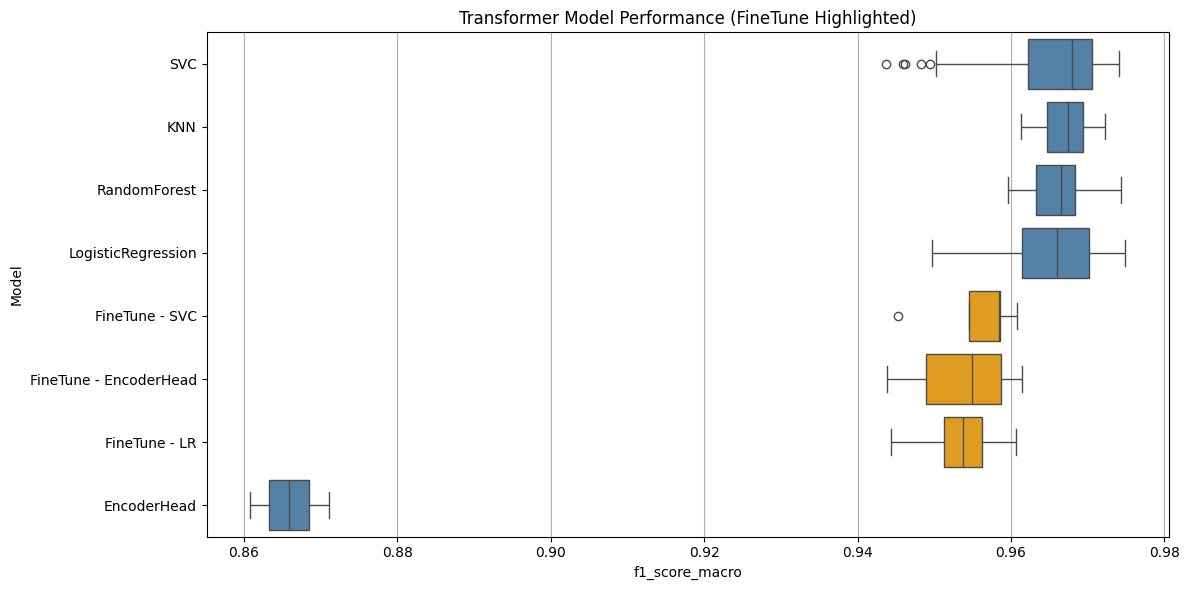

In [15]:
class_df = res[res["config_number"].str.contains("RashidNLP/Finance-Sentiment-Classification")]

class_df = class_df[:-20]

class_df = pd.concat([class_df, fine_df], axis=0)

# Order by median f1 score
median_order = (
    class_df.groupby("model")["f1_score_macro"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Create config label mapping: "Config 1", "Config 2", ...
config_labels = {cfg: f"{cfg.split('(')[0]}" for cfg in median_order}
config_labels = {
    k: ("FineTune - EncoderHead" if v == "FineTune - ClassificationHead" else v)
    for k, v in config_labels.items()
}

# Map short labels for plotting
class_df["short_label"] = class_df["model"].map(config_labels)
class_df["short_label"] = class_df["short_label"].replace(
    {"FineTune - ClassificationHead": "FineTune - EncoderHead"}
)


# Create color palette: FineTune models get a different color
unique_labels = [config_labels[cfg] for cfg in median_order]
palette = {
    label: "orange" if "FineTune" in label else "steelblue"
    for label in unique_labels
}

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=class_df,
    x="f1_score_macro",
    y="short_label",
    order=unique_labels,
    ax=ax,
    orient="h",
    palette=palette
)

ax.set_yticklabels(unique_labels)
ax.set_title("Transformer Model Performance (FineTune Highlighted)")
ax.set_xlabel("f1_score_macro")
ax.set_ylabel("Model")
ax.grid(True, axis='x')
plt.tight_layout()

# Top configuration

In [53]:
print(f"Best configuration based on mean f1_score_macro: {sorted_means.index[0]}")
print(f"Best score: {sorted_means.iloc[0]:.4f}")

Best configuration based on mean f1_score_macro: preprocess=False|regex=False|RashidNLP/Finance-Sentiment-Classification|SVC|C=10|kernel=rbf|gamma=scale|probability=True|random_state=42
Best score: 0.9720


In [34]:
print(f"Mean F1-Macro for the best configuration: {res.groupby('final_config')['f1_score_macro'].mean().sort_values(ascending=False).iloc[0]:.4f}")
print(f"Mean accuracy for the best configuration: {res.groupby('final_config')['accuracy'].mean().sort_values(ascending=False).iloc[0]:.4f}")
print(f"Mean precision for the best configuration: {res.groupby('final_config')['precision_macro'].mean().sort_values(ascending=False).iloc[0]:.4f}")
print(f"Mean recall for the best configuration: {res.groupby('final_config')['recall_macro'].mean().sort_values(ascending=False).iloc[0]:.4f}")


Mean F1-Macro for the best configuration: 0.9728
Mean accuracy for the best configuration: 0.9776
Mean precision for the best configuration: 0.9755
Mean recall for the best configuration: 0.9703


In [52]:
top_config["f1_class_0"].mean(), top_config["f1_class_1"].mean(), top_config["f1_class_2"].mean()

(0.9756865488795785, 0.9590730048208984, 0.9837050220074554)